<a href="https://colab.research.google.com/github/turtler12/CV_Homework/blob/main/pset5_6s058.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6.S058 PSET 5

Welcome to Pset 5! The aim of this problem set is to study different issues that appear when deploying models for real applications. These issues lead to a wide range of societal and ethical issues, some of which this problem set will try to briefly illustrate.

## Logistics

To speed up the execution of the experiments we recommend using GPU acceleration. If you run this notebook on Google Colab, select GPU as your runtime type as follows:

Runtime $\rightarrow$ Change runtime type $\rightarrow$ Hardware accelerator $\rightarrow$ GPU $\rightarrow$ Save.


Training a single model with the default parameters for 40 epochs will take less than 15 minutes using a GPU in Google Colab (which should be available to you for free) or 3.5 hours using a CPU. You should at least train one model for Q1, but the rest of the problem set can be completed either with your model or a model provided by the instructors.

If you get the message: "Notebook requires high RAM", press OK and ignore it.


# Set up environment and download resources



If you want to store data and models in your drive, set the following variable use_gdrive to True, and possibly modify *data_dir* to point to a specific folder. This will allow you to avoid retraining models if your notebook crashes. If set to True, it will ask for permission for the Colab to access your Google Drive.

In [1]:
use_gdrive = False

In [2]:
import os
from tqdm import tqdm

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/notebooks_data/Pset5/data"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/datasets'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(pretrained_models, exist_ok=True)
os.makedirs(q2c_data_dir, exist_ok=True)

mias_dataset_dir = datasets_dir + '/mias_dataset'
external_dataset_dir = datasets_dir + '/external_dataset'

In [3]:
# Download MIAS dataset
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/mias_dataset.zip -O {downloads_dir}/mias_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/external_dataset.zip -O {downloads_dir}/external_dataset.zip
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/q2c_data.zip -O {downloads_dir}/q2c_data.zip

!unzip -o {downloads_dir}'/mias_dataset.zip' -d {mias_dataset_dir}
!unzip -o {downloads_dir}'/external_dataset.zip' -d {external_dataset_dir}
!unzip -o {downloads_dir}'/q2c_data.zip' -d {q2c_data_dir}

!rm -rf {downloads_dir}

# Download instructors pretrained model
!wget http://6.869.csail.mit.edu/sp22/psets/pset6_serc_data/pretreained_models/instructors_model/model.pth -O {pretrained_models}/instructors_model.pth

Streaming output truncated to the last 5000 lines.
  inflating: ./data/datasets/mias_dataset/train/normal/A_0502_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0501_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0500_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0503_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.LEFT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.LEFT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.RIGHT_MLO.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0505_1.RIGHT_CC.jpg  
  inflating: ./data/datasets/mias_dataset/train/normal/A_0504_1.RIGHT_CC.jpg  
 

# **Problem 1** Train an Image Classifier

Experiment with some of the following hyperparameters, techniques, and model types by modifying the cells that follow:

*   Starting with a pretrained model
*   Data augmentation
*   Weight initialization
*   Dropout
*   Residual connections (ResNet) and dense connections (DenseNet), compared to networks without them (VGGNet, AlexNet)
*   Number of layers, or number of layer features
*   Type of optimizer
*   Learning rate and/or schedule
*   Early stopping



For the rest of the problem set, you can either use your model (save the best performing one) or the one trained by the instructors (which is automatically downloaded in the notebook). If the test performance of your own model is less than **93%**, please use the latter. Note only 90% test performance required for full credit.

## Section 1: Training a Model

This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>

You are free to delete this code entirely and start from scratch, or modify it in whatever way you choose to implement your proposed modifications.

### Dependencies

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL
import random
from collections import defaultdict
from scipy import ndimage
import math
import cv2
import random
import sys
import requests
np.set_printoptions(threshold=sys.maxsize)

# For reproducibility
torch.manual_seed(1234)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


### Initialize an Empty Model

First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

We also add a `resume_from` argument to specify model weights to load, In case you save a model and want to use it again.

In [5]:
def initialize_model(model_name, num_classes, resume_from=None, use_pretrained=False):
    model_ft = None
    input_size = 0

    # Helper to load weights if requested
    def get_weights(model_enum):
        return model_enum.DEFAULT if use_pretrained else None

    if model_name == "resnet":
        weights = get_weights(models.ResNet18_Weights)
        model_ft = models.resnet18(weights=weights)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        weights = get_weights(models.ResNet50_Weights)
        model_ft = models.resnet50(weights=weights)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        weights = get_weights(models.AlexNet_Weights)
        model_ft = models.alexnet(weights=weights)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        weights = get_weights(models.VGG11_BN_Weights)
        model_ft = models.vgg11_bn(weights=weights)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        weights = get_weights(models.SqueezeNet1_0_Weights)
        model_ft = models.squeezenet1_0(weights=weights)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        weights = get_weights(models.DenseNet121_Weights)
        model_ft = models.densenet121(weights=weights)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise ValueError(f"Invalid model name: {model_name}")

    if resume_from is not None:
        print(f"Loading weights from {resume_from}")
        model_ft.load_state_dict(torch.load(resume_from, map_location='cpu'))

    return model_ft, input_size

### Data Loading

With the input size from the model, we can now load the dataset

In [6]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.

    # We convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from the mean/stdev of the ImageNet training set which was used to pretrain our models.

    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(dataset_dir, input_size, batch_size, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        'train': transform,
        'val': transform,
        'test': transform
    }
    # Create training, validation and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    return dataloaders_dict

### Training
Next, let's make a helper function that trains the given model

In [7]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found,
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

### Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [8]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    # optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

### Parameters

Here, we set up some of the various parameters that we can change to run the code. You can add change the values given here, or add new ones! This is just a template.

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, 3 here, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs (passes through the dataset) we want to run.




In [9]:
#TODO:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet] and parameters to adjust
# You can add your own, or modify these however you wish!

model_name = "densenet" ##TODO

# Number of classes in the dataset, normal, benign, malignant
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16 ##TODO

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
num_epochs = 20

# Learning rate
learning_rate = 0.001 ##TODO

#END TODO

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k
pretrained = True

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

### Tying it all together - Training

In [10]:
# Initialize the model for this run
# train model_1
model_1, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Move the model to the gpu if needed
model_1 = model_1.to(device)

optimizer_1 = make_optimizer(model_1, learning_rate)

# Train the model!
trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1,
                                                                     dataloaders=dataloaders,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs)
del model_1, optimizer_1, trained_model_1

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 99.5MB/s]


Epoch 1/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1982 Acc: 0.9127


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 5.5056 Acc: 0.1419

Epoch 2/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1410 Acc: 0.9326


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.3981 Acc: 0.8845

Epoch 3/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1288 Acc: 0.9416


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.2092 Acc: 0.9043

Epoch 4/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1148 Acc: 0.9432


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1070 Acc: 0.9439

Epoch 5/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0958 Acc: 0.9529


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.8834 Acc: 0.8845

Epoch 6/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1268 Acc: 0.9387


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.9367 Acc: 0.8746

Epoch 7/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1099 Acc: 0.9387


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0962 Acc: 0.9472

Epoch 8/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1064 Acc: 0.9468


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 23.8691 Acc: 0.0660

Epoch 9/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1094 Acc: 0.9375


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0990 Acc: 0.9472

Epoch 10/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1016 Acc: 0.9391


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0858 Acc: 0.9472

Epoch 11/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0882 Acc: 0.9472


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0978 Acc: 0.9340

Epoch 12/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0938 Acc: 0.9464


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1039 Acc: 0.9340

Epoch 13/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1014 Acc: 0.9448


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1015 Acc: 0.9406

Epoch 14/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1067 Acc: 0.9472


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 8.1592 Acc: 0.8812

Epoch 15/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1092 Acc: 0.9420


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0857 Acc: 0.9538

Epoch 16/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9489


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.1973 Acc: 0.6535

Epoch 17/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0864 Acc: 0.9517


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1157 Acc: 0.9472

Epoch 18/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0872 Acc: 0.9521


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.0851 Acc: 0.9472

Epoch 19/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0945 Acc: 0.9448


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 5.0164 Acc: 0.8812

Epoch 20/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0912 Acc: 0.9501


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 3.1723 Acc: 0.8812

Training complete in 9m 25s
Best val Acc: 0.953795


### Load trained models

In [11]:
# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours = model_yours.to(device)

# Load weights for model_yours
model_yours.load_state_dict(torch.load(weights_file))

# Load instructors model:
model_inst = torch.load(pretrained_models + '/instructors_model.pth', weights_only=False)
model_inst = model_inst.to(device)

# set models to eval mode
model_yours = model_yours.eval()
model_inst = model_inst.eval()



## Section 2: Inference using a model

Now that we've trained a model, we would like to use it for inference on the test data. We will use a function that can compute top-k performance (i.e., whether the correct prediction is in the top-k predicted classes) but for this problem set, we will set k = 1, as there are only 3 classes.


In [12]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []

    # Iterate over data.
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1)
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None

    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels

In [13]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

val_loss_inst, val_top1_inst, _, val_labels_inst = evaluate(model_inst, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_inst, test_top1_inst, _, test_labels_inst = evaluate(model_inst, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

print("Instructors model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_inst))
print("Test Top-1 Accuracy: {}".format(test_top1_inst))

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.9537953795379538
Test Top-1 Accuracy: 0.9411764705882353
Instructors model: 
Val Top-1 Accuracy: 0.9636963696369637
Test Top-1 Accuracy: 0.9477124183006537


Select either your model or the instructor model for the next questions. If your model does not achieve high accuracy (at least 93% on the test set), you should use the instructors model (model_inst).

In [14]:
model = model_inst
# model = model_yours

# **Problem 2** Metrics: Accuracy isn't everything

Let's define a function to get detailed evaluation results on the test set.

In [15]:
# Wrapper to easily evaulate a model given a model and the set of dataloaders
def get_eval_results(model, dataloaders):
    model.eval()
    true_label_list = []
    outputs_list = []
    predicted_label_list = []
    original_image_list = []

    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            true_label_list.append(labels)
            original_image_list.append(inputs)
            outputs_list.append(outputs)
            _, preds = torch.topk(outputs, k=1, dim=1)
            predicted_label_list.append(preds)
    return torch.concat(true_label_list).unsqueeze(-1).cpu().numpy(), \
           torch.concat(predicted_label_list).cpu().numpy(), \
           torch.softmax(torch.concat(outputs_list), dim=1).cpu().numpy(), \
           torch.concat(original_image_list).cpu().numpy()

## Please make sure you understand what outputs means here
y_label, y_pred, outputs, inputs =  get_eval_results(model, dataloaders)

  0%|          | 0/20 [00:00<?, ?it/s]


###**(a)** Confusion Matrix

The first simple method that we will use to delve deeper into the results is the confusion matrix. Complete the function below and plot your confusion matrix.


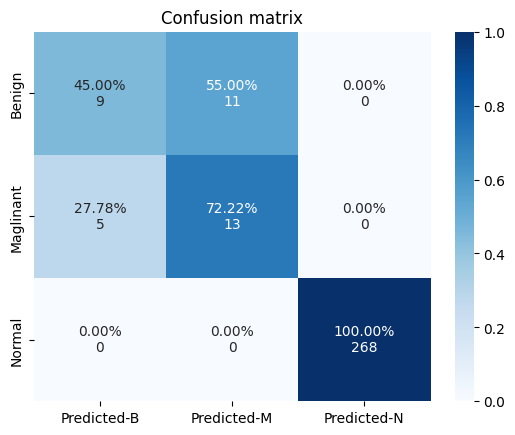

In [16]:
### Complete your code here to plot your confusion matrix.
### Please avoid using sklearn.metrics.confusion_matrix in your function: build your confusion matrix from scratch! You may, however, want to plot its output to check if you're doing the right thing!
import seaborn as sns

def confusion_matrix(y_label, y_pred):
  num_classes = len(np.unique(y_label))
  conf_matrix = np.zeros((num_classes, num_classes))

  ### START TODO: calculate confusion matrix from labels and predictions
  y_true = np.array(y_label).flatten().astype(int)
  y_hat  = np.array(y_pred).flatten().astype(int)
  classes = np.unique(y_true)
  C = len(classes)
  # if your labels aren't exactly 0..C-1, map them:
  class_to_idx = {c:i for i, c in enumerate(classes)}
  cm = np.zeros((C, C), dtype=int)
  for t, p in zip(y_true, y_hat):
      i = class_to_idx[t]
      j = class_to_idx[p]
      cm[i, j] += 1
  return cm


def plot_confusion_matrix(y_label, y_pred, title='Confusion matrix'):
  matplotlib.rcParams["figure.dpi"] = 100

  cm = confusion_matrix(y_label, y_pred)

  cf_matrix = cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 3, axis=1)
  group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
  # percentage based on true label
  gr = (cm/np.repeat(np.expand_dims(np.sum(cm, axis=1), axis=-1), 3, axis=1)).flatten()
  group_percentages = ['{0:.2%}'.format(value) for value in gr]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_counts)]

  labels = np.asarray(labels).reshape(3, 3)

  plt.plot()

  hm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',
                   xticklabels=['Predicted-B','Predicted-M', 'Predicted-N'],
                   yticklabels=['Benign','Maglinant', 'Normal'])
  hm.set(title=title)
  plt.show()


plot_confusion_matrix(y_label, y_pred)

###**(b)** Precision-Recall Curve

Assume that the malignant class is our positive class, and the rest are negative classes. In this scenario, a positive prediction happens when our model's prediction for class malignant is *above a user-defined threshold*. That means that a True Positive (TP) happens when we have a positive prediction and the ground truth label is malignant. A False Positive (FP) happens when we have a positive prediction and the ground truth label is something other than malignant. True negatives (TN) and false negatives (FN) follow the same logic.

Remember that Precision = TP/(TP+FP) and Recall = TP/(TP+FN).

**Calculate precision and recall for 1000 evenly spaced thresholds between 0 and 1, and plot the precision-recall curve of your selected model. Then, compute the AUC leveraging the function trapezoid from numpy, and display the AUC on the plot.** Your output for this question should be one plot, with precision on the Y axis and recall on the X axis.




  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-17-f0e9e91fd33f>:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precisions, recalls)


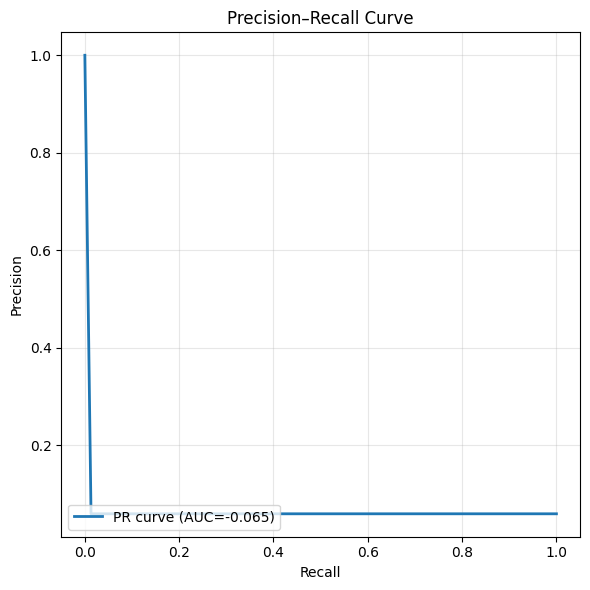

In [17]:
### write your code here to plot your precision-recall curve for the model
### please plot it without using metrics packages here for better understanding

### use the returned values from the get_eval_results() above
### START TODO

### END TODO

import numpy as np
import matplotlib.pyplot as plt

# get full test‐set scores
y_label, y_pred, outputs, _ = get_eval_results(model, dataloaders)

# malignant = label 1 is our “positive” class
y_true = (y_label == 1).astype(int)
scores = outputs[:, 1]   # P(malignant) from softmax outputs

# sweep thresholds
thresholds = np.linspace(0.0, 1.0, 1000)
precisions = []
recalls    = []

for t in thresholds:
    y_bin = (scores >= t).astype(int)
    tp = np.sum((y_bin == 1) & (y_true == 1))
    fp = np.sum((y_bin == 1) & (y_true == 0))
    fn = np.sum((y_bin == 0) & (y_true == 1))
    # avoid zero‐division
    precision = tp/(tp+fp) if (tp+fp)>0 else 1.0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls    = np.array(recalls)

# compute area under PR curve: integrate precision w.r.t. recall
auc_pr = np.trapz(precisions, recalls)

# plot
plt.figure(figsize=(6,6))
plt.plot(recalls, precisions, lw=2, label=f'PR curve (AUC={auc_pr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In your pdf report, please include your code and figures and ensure you also answer the following:

**What should you look at when you are trying to improve a model? Come up
with an example where you might care more about high precision and an example
where you might care more about high recall. Why might you want to look at
the precision-recall curve? Explain your reasoning.**

# Problem 3 Evaluation on an External Dataset


## (a) Compare performances


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Top-1 Acc: 0.9477124183006537
External Top-1 Acc: 0.8790849673202614


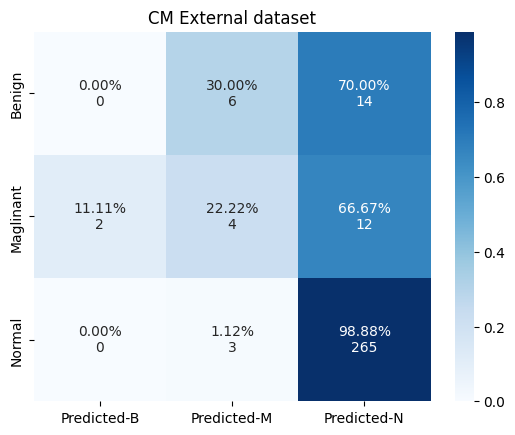

In [ ]:
dataloaders_external = get_dataloaders(external_dataset_dir, input_size, batch_size, shuffle_datasets)

test_loss, test_top1, gt_labels, pred_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 1)
test_loss_ext, test_top1_ext, gt_labels_ext, pred_labels_ext = evaluate(model, dataloaders_external['test'], criterion, is_labelled = True, generate_labels = True, k = 1)

print("Top-1 Acc: {}".format(test_top1))
print("External Top-1 Acc: {}".format(test_top1_ext))

plot_confusion_matrix(gt_labels_ext, pred_labels_ext, title='CM External dataset')


## (b) Compare examples




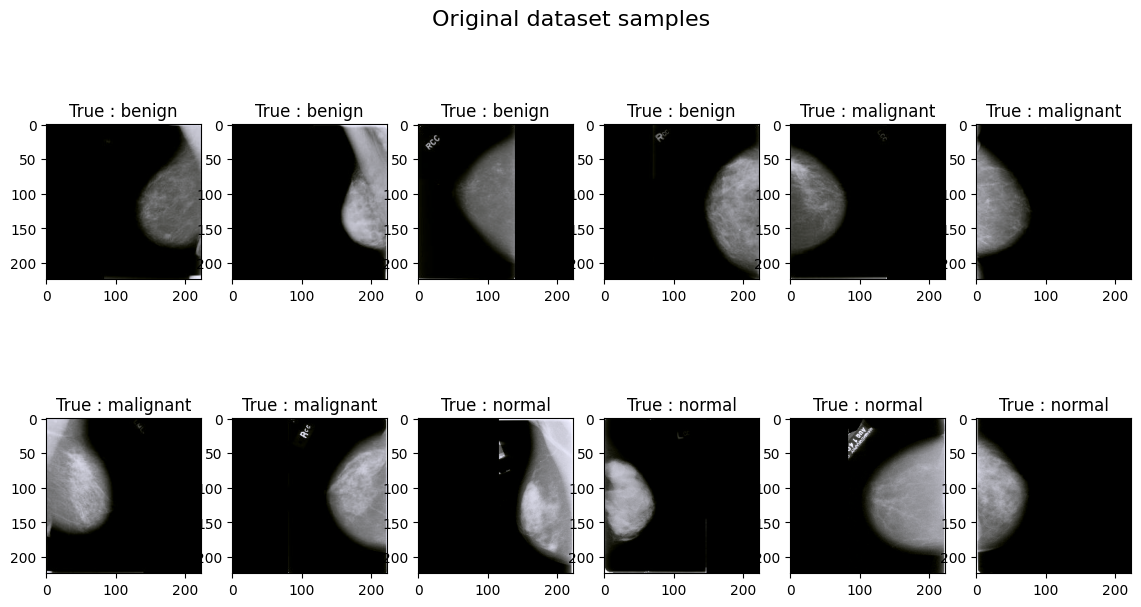

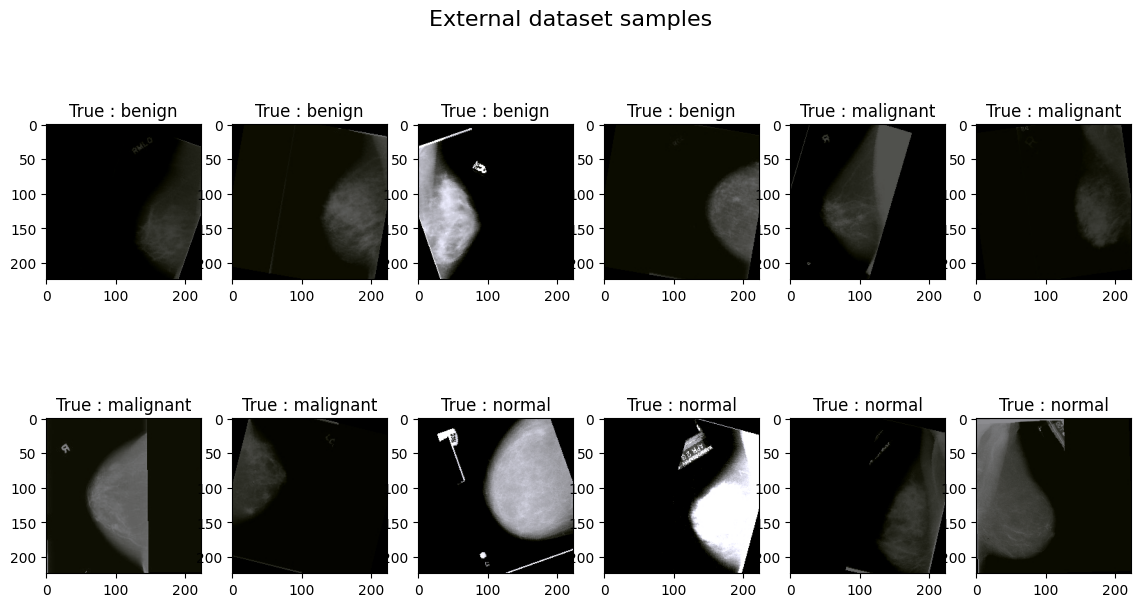

In [ ]:
import random
from collections import defaultdict

def plot_samples(dataloaders_external, title=''):
  fig, axs = plt.subplots(2, 6, figsize=(14, 7))
  fig.suptitle(title, fontsize=16)

  dataset = dataloaders_external['test'].dataset
  indices_per_class = defaultdict(list)
  for i, (_, c) in enumerate(dataset.imgs):
    indices_per_class[c].append(i)

  random.seed(1337)
  indices = []
  for c in range(3):
    indices.extend(random.sample(indices_per_class[c], 4))

  # remove normalize transforms for plotting
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )

  for dataset_i, ax in zip(indices, axs.flatten()):
    img, class_idx = dataset[dataset_i]
    img = inv_normalize(img)
    ax.set_title('True : %s' %(dataset.classes[class_idx]))
    if len(img.shape) == 2:
      img = np.tile(img[:,:,None], (1,1,3))
    img = np.array((img*255).clip(0, 255), dtype='uint8')
    ax.imshow(img.transpose((1,2,0)))

# Plot some samples of each of the datasets:
plot_samples(dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

## (c) New transformations
Use some of the available PyTorch transformations in:

https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor



TypeError: 'NoneType' object is not callable

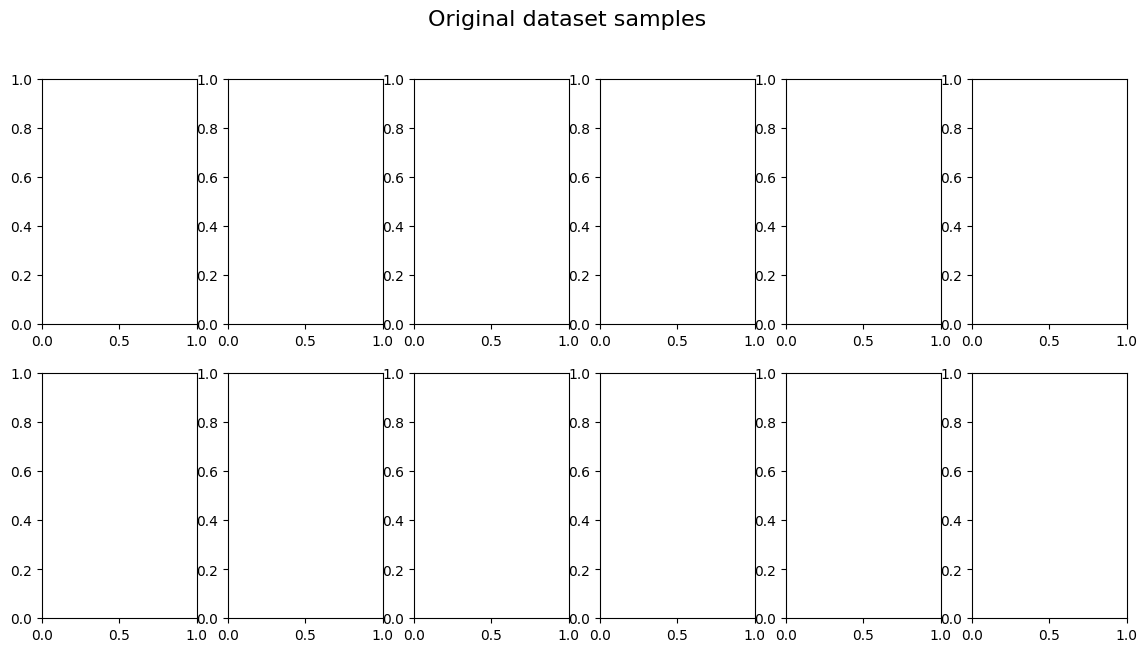

In [ ]:
from torchvision.transforms.functional import to_grayscale
# START TODO:
external_transforms = None #change to transformations

# END TODO
transform = transforms.Compose([external_transforms,
                                get_image_transforms()])

modified_original_dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets, transform)
plot_samples(modified_original_dataloaders, 'Original dataset samples')
plot_samples(dataloaders_external, 'External dataset samples')

# **Problem 4** Class Imbalance


In [ ]:
from collections import defaultdict
# First we will compute statistics of the dataset:
dataloaders = get_dataloaders(mias_dataset_dir, input_size, batch_size, shuffle_datasets)
train_dataset = dataloaders['train'].dataset

samples_per_class = [0 for _ in range(3)]
for _, class_idx in train_dataset:
  samples_per_class[class_idx] += 1

print("Samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset.classes[c_idx], samples_per_class[c_idx]))

Samples per class:
Class 0 (benign): 186 samples
Class 1 (malignant): 132 samples
Class 2 (normal): 2146 samples


###**(a)** Loss reweighting

Complete the line of code specified to compute (and print out) the weights per class to balance the class losses.

In [ ]:
total_samples = sum(samples_per_class)

# TODO: Compute the weights per class so that the loss is balanced.
#       We are expecting one weight per class (weights_per_class.shape = [3])
#       If done correctly, the sum of weights over all samples should sum up to total_samples

# w_i = total_samples / (num_classes * count_i)
weights_per_class = torch.tensor(
    [ total_samples / (num_classes * cnt) for cnt in samples_per_class ],
    dtype=torch.float
)

# END TODO

reweighted_criterion = nn.CrossEntropyLoss(weight=weights_per_class)

# DO NOT REMOVE THIS LINE:
print(weights_per_class)

tensor([4.4158, 6.2222, 0.3827])


###**(b)** Dataset rebalancing
Complete the following lines to modify the data loader so that samples for the three classes are balanced. For simplicity, you are allowed to select an element at random, and ignore the *item* argument of the dataset.__getitem__ function.

Then, excecute the training loop with the modified dataset/dataloader and print the number of samples per class in the rebalanced dataset with the code provided

In [ ]:
import random
from collections import defaultdict

class RebalancedDataset(datasets.ImageFolder):
  def __init__(self, class_probabilities, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.class_probabilities = class_probabilities
    self.items_per_class = defaultdict(list)

    for item_i, (_, c) in enumerate(self.imgs):
      self.items_per_class[c].append(item_i)

  def __getitem__(self, i_ignored):
    # ignores argument, and returns an element at random with reweighted class
    if i_ignored >= len(self):
      raise IndexError('Index is too large') # Exception required so that the iterator ends after len(self) samples

    # TODO: select a class at random following self.class_probabilities, and then select a random element for the class

    class_i = random.choices(
            population=list(range(len(self.class_probabilities))),
            weights=self.class_probabilities,
            k=1
    )[0] #select class at random
    # pick one sample‐index from that class uniformly
    e = random.choice(self.items_per_class[class_i]) # select a random element for the class

    # ENDTODO
    return super().__getitem__(e)


In [ ]:
# Replicates the original get_dataloaders, but in this case we substitute the training dataset for the RebalancedDataset
def get_dataloaders_rebalanced(class_probabilities, dataset_dir, input_size, batch_size, shuffle = True):
    data_transforms = {
        'train': get_image_transforms(),
        'val': get_image_transforms(),
        'test': get_image_transforms()
    }

    # Create training and validation datasets
    image_datasets = {'train': RebalancedDataset(class_probabilities, os.path.join(dataset_dir, 'train'), data_transforms['train']),
                      'val': datasets.ImageFolder(os.path.join(dataset_dir, 'val'), data_transforms['val']),
                      'test': datasets.ImageFolder(os.path.join(dataset_dir, 'test'), data_transforms['test'])}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}
    return dataloaders_dict

In [ ]:
class_probabilities = [1/3 for _ in range(3)]
dataloaders_rebalanced = get_dataloaders_rebalanced(class_probabilities, mias_dataset_dir, input_size, batch_size, shuffle_datasets)

train_dataset_rebalanced = dataloaders_rebalanced['train'].dataset


In [ ]:
from collections import defaultdict

samples_per_class_rebalanced = [0 for _ in range(3)]
for _, class_idx in tqdm(train_dataset_rebalanced):
  samples_per_class_rebalanced[class_idx] += 1

print("Rebalanced samples per class:")
for c_idx in range(3):
  print("Class {} ({}): {} samples".format(c_idx, train_dataset_rebalanced.classes[c_idx], samples_per_class_rebalanced[c_idx]))



  0%|          | 0/2464 [00:00<?, ?it/s]

Rebalanced samples per class:
Class 0 (benign): 831 samples
Class 1 (malignant): 767 samples
Class 2 (normal): 866 samples


###**(c)** Results of approaches for addressing class imbalance

Train the models with the modified criterion and rebalanced dataloader by running the next two cells.

In [ ]:
model_reweighted, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# assume `device` is torch.device("cuda:0") if available
weights_per_class = torch.tensor(
    [ total_samples/(num_classes*cnt) for cnt in samples_per_class ],
    dtype=torch.float,
    device=device      # ← build it on the GPU
)

reweighted_criterion = nn.CrossEntropyLoss(weight=weights_per_class)

model_reweighted = model_reweighted.to(device)
optimizer_reweighted = make_optimizer(model_reweighted, learning_rate)
trained_reweighted, validation_history_reweighted, train_history_reweighted = train_model(model=model_reweighted,
                                                                                          dataloaders=dataloaders,
                                                                                          criterion=reweighted_criterion,
                                                                                          optimizer=optimizer_reweighted,
                                                                                          save_dir=save_dir,
                                                                                          save_all_epochs=save_all_epochs,
                                                                                          num_epochs=num_epochs)

Epoch 1/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.7451 Acc: 0.8113


  0%|          | 0/19 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e75ec3ec5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
model_rebalanced, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

model_rebalanced = model_rebalanced.to(device)
optimizer_rebalanced = make_optimizer(model_rebalanced, learning_rate)
trained_rebalanced, validation_history_rebalanced, train_history_rebalanced = train_model(model=model_rebalanced,
                                                                                          dataloaders=dataloaders_rebalanced,
                                                                                          criterion=criterion,
                                                                                          optimizer=optimizer_rebalanced,
                                                                                          save_dir=save_dir,
                                                                                          save_all_epochs=save_all_epochs,
                                                                                          num_epochs=num_epochs)

Epoch 1/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.4964 Acc: 0.7573


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.3506 Acc: 0.2673

Epoch 2/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3740 Acc: 0.8247


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1707 Acc: 0.9208

Epoch 3/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3595 Acc: 0.8348


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 3.7254 Acc: 0.2541

Epoch 4/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3228 Acc: 0.8547


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.3287 Acc: 0.8779

Epoch 5/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.3283 Acc: 0.8551


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.8870 Acc: 0.8581

Epoch 6/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.2808 Acc: 0.8811


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.1690 Acc: 0.9340

Epoch 7/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.2216 Acc: 0.9095


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3945 Acc: 0.8614

Epoch 8/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1380 Acc: 0.9476


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.2463 Acc: 0.9472

Epoch 9/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1726 Acc: 0.9298


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.2922 Acc: 0.9175

Epoch 10/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1131 Acc: 0.9558


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 4.0988 Acc: 0.3927

Epoch 11/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1874 Acc: 0.9432


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.5157 Acc: 0.9340

Epoch 12/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0964 Acc: 0.9606


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3677 Acc: 0.9307

Epoch 13/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0668 Acc: 0.9744


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.4264 Acc: 0.9241

Epoch 14/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.1146 Acc: 0.9533


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3082 Acc: 0.9373

Epoch 15/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0920 Acc: 0.9651


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.3537 Acc: 0.3927

Epoch 16/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0832 Acc: 0.9752


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.1996 Acc: 0.8812

Epoch 17/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0603 Acc: 0.9801


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.6929 Acc: 0.8680

Epoch 18/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0684 Acc: 0.9769


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3818 Acc: 0.9340

Epoch 19/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0081 Acc: 0.9984


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.4824 Acc: 0.9439

Epoch 20/20
----------


  0%|          | 0/154 [00:00<?, ?it/s]

train Loss: 0.0292 Acc: 0.9923


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 0.3673 Acc: 0.9538

Training complete in 9m 29s
Best val Acc: 0.953795


Finally, plot the confusion matrix for the three models by running the cell below, and then answer the questions specified in the PDF.


  0%|          | 0/20 [00:00<?, ?it/s]

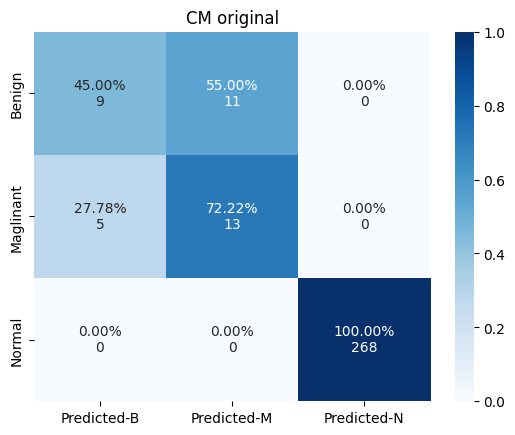

  0%|          | 0/20 [00:00<?, ?it/s]

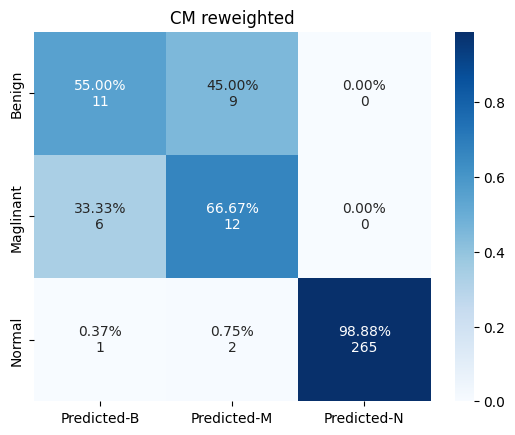

  0%|          | 0/20 [00:00<?, ?it/s]

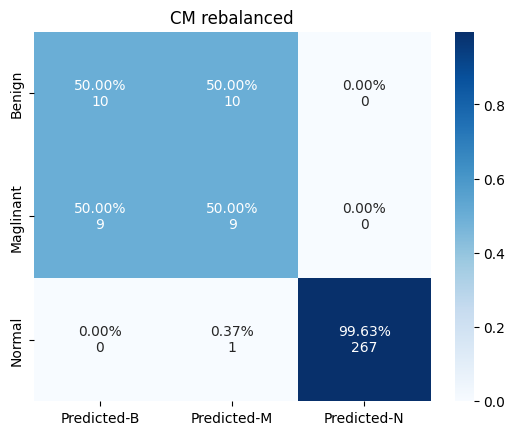

In [ ]:
y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title='CM original')

y_label_reweighted, y_pred_reweighted, _, _ =  get_eval_results(model_reweighted, dataloaders)
plot_confusion_matrix(y_label_reweighted, y_pred_reweighted, title='CM reweighted')

y_label_rebalanced, y_pred_rebalanced, _, _ =  get_eval_results(model_rebalanced, dataloaders)
plot_confusion_matrix(y_label_rebalanced, y_pred_rebalanced, title='CM rebalanced')

# Problem 5 - Texture Synthesis
As discussed in class, the Efros and Leung algorithm synthesizes a new texture by performing an exhaustive search of a source texture for each synthesized pixel in the target image, in which sum-of-squared differences (SSD) is used to associate similar image patches in the source image with that of the target. The algorithm is initialized by randomly selecting a $3 \times 3$ patch from the source texture and placing it in the center of the target texture. The boundaries of this patch are then recursively filled until all pixels in the target image have been considered. Implement the Efros and Leung algorithm as the following Python function:
```
synthIm = synth_texture(sample, w, s)
```
where `sample` is the source texture image, `w` is the width of the search window, and `s=(ht, wt)` specifies the height and width of the target image `synthIm`. As described above, this algorithm will create a new target texture image, initialized with a $3 \times 3$ patch from the source image. It will then grow this patch to fill the entire image. As discussed in the textbook, when growing the image, unfilled pixels along the boundary of the block of synthesized values are considered at
each iteration of the algorithm. A useful technique for recovering the location of these pixels is morphological dilation, an operation that expands image regions. Specifically, we use `scipy.ndimage.binary_dilation`, `numpy.nonzero`, and/or `numpy.ix_` to recover the unfilled pixel locations along the boundary of the synthesized block in the target image. We have already provided some of the code for this part (which you should not need to modify).

In order to implement `synth_texture()`, you will first write a subroutine that for a given pixel in the target image, returns a list of matching patches in the source texture. This function should have the following syntax:
```
bestMatches = find_matches(template, sample, G)
```
where `bestMatches` is the list of matches, `template` is the $w \times w$ image template associated with a pixel of the target image, `sample` is the source texture image, and `G` is a 2D Gaussian mask discussed below. This routine is called by `synth_texture` and a pixel value is randomly selected from `bestMatches` to synthesize a pixel of the target image.

`bestMatches` is a list of patch locations represented by their center pixel coordinates. You should select patches based on both their absolute and relative SSD errors: to be included in `bestMatches`, the SSD error must be below a threshold $\delta$, and the SSD error must also be below the minimum SSD error times $(1+\epsilon)$. Efros and Leung use threshold values of $\epsilon = 0.1$ and $\delta = 0.3$.

Note that `template` can have values that have not yet been filled in by the image growing routine. Mask the template image such that these values are not
considered when computing SSD. Efros and Leung suggest using the following
image mask:
```
mask = G .* validMask
```
where `validMask` is a square mask of width $w$ that is 1 where the template is filled, 0 otherwise and `G` is a 2D zero-mean Gaussian with standard deviation $\sigma = w/6.4$ sampled on a $w \times w$ grid centered about its mean. `G` can be pre-computed using the `scipy.ndimage.gaussian_filter` routine or you can compute it yourself using the Gaussian equation. The purpose of the Gaussian is to down-weight pixels that are farther from the center of the template. You will need to normalize the mask such that its elements sum to 1.

In [18]:
# Download images
r = requests.get("http://6.869.csail.mit.edu/sp22/pset7/rings.jpg", timeout=0.5)
if r.status_code == 200:
    with open("rings.jpg", 'wb') as f:
        f.write(r.content)

In [35]:
# @title Helper functions
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(float) / info.max # Divide all values by the largest possible value in the datatype

def im2col_sliding(A, BSZ, stepsize=1):
    # This function is similar to the `im2col` function from MATLAB. It rearrange image blocks into columns.
    # Run the following line and check out the results to get more intuition
    # r = np.arange(25).reshape(5, 5); s = (3, 3); print(r); print(im2col_sliding(r, s).shape); print(im2col_sliding(r, s))
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1
    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols

# 4 points: implement find_matches()

In [36]:
import numpy as np
from scipy import ndimage
import math

def find_matches(template: np.ndarray,
                 sample:   np.ndarray,
                 G:        np.ndarray) -> list:
    """
    template:   w×w×C patch with NaNs where not yet filled
    sample:     H×W×C source image
    G:          w×w (or w×w×C) Gaussian kernel, zero‐mean, sum = 1
    Returns a list of center‐pixel RGB values (length ≥1).
    """
    # ensure G is w×w×C
    w = G.shape[0]
    C = sample.shape[2] if sample.ndim==3 else 1
    if G.ndim == 2:
        G = G[:, :, None]
    if G.shape[2] != C:
        # replicate across channels
        G = np.repeat(G, C, axis=2)

    # Step 1a: build a 2D valid mask from the template's first channel
    valid2d = (~np.isnan(template[:,:,0])).astype(float)   # shape (w,w)
    # replicate to 3D so we can mask G
    valid3d = valid2d[:,:,None] * np.ones((1,1,C))

    # Step 1b: mask and renormalize
    maskedG = G * valid3d                   # shape (w,w,C)
    maskedG /= maskedG.sum()                # make sum(maskedG)==1

    # flatten to a weighting vector
    mask1 = maskedG.ravel(order='F')        # length = w*w*C

    # Step 2: extract **all** w×w patches from sample
    # build a (w*w*C) × nBlocks array of columnized patches
    patches = []
    for c in range(C):
        channel = sample[:,:,c]
        # im2col_sliding returns shape (w*w, nBlocks)
        p = im2col_sliding(channel, (w,w), stepsize=1)
        patches.append(p)
    patches = np.vstack(patches)            # shape = (w*w*C, nBlocks)

    # flatten the partially‐filled template
    tvect = template.ravel(order='F')       # length = w*w*C

    # Step 3: compute weighted SSD
    diffs = patches - tvect[:,None]         # broadcast
    ssd   = np.sum((diffs**2) * mask1[:,None], axis=0)

    # Step 4: threshold by ε, δ
    eps, delta = 0.1, 0.3
    mssd       = ssd.min()
    idxs       = np.where((ssd <= mssd*(1+eps)) & (ssd <= delta))[0]

    # if nothing found, fall back to the absolute best match
    if idxs.size == 0:
        idxs = np.array([ssd.argmin()])

    # Step 5: convert block‐indices back to center coords, pick pixel
    H, W = sample.shape[:2]
    nrows, ncols = H - w + 1, W - w + 1
    best = []
    for k in idxs:
        i = k // ncols
        j = k %  ncols
        ci = i + w//2
        cj = j + w//2
        best.append(sample[ci, cj].copy())

    return best

# 2 points: implement synth_texture()


In [37]:
# I changed some of the parts outside of the TODO but only because I had to fix the shape/broadcasting so that it wouldn't compile with an error

def synth_texture(sample, w, s, verbose=False):
    """
    Non‐parametric texture synthesis (Efros & Leung).
      sample: H×W×C source texture (uint8 or float)
      w:      odd window size (e.g. 5, 7, 13)
      s:      [H_out,W_out] target size
    Returns synthIm: H_out×W_out×C float in [0,1].
    """
    sample = im2double(sample)
    seed_size = 3
    Hs, Ws, C = sample.shape
    Ho, Wo   = s

    # build the w×w zero‐mean Gaussian (σ = w/6.4), sum to 1
    ax = np.arange(w) - (w-1)/2
    xx, yy = np.meshgrid(ax, ax)
    sigma   = w/6.4
    Gmono   = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    Gmono  /= Gmono.sum()
    G       = Gmono[:,:,None].repeat(C, axis=2)

    # initialize output with NaNs
    synthIm = np.full((Ho,Wo,C), np.nan, dtype=float)

    # seed: copy one random 3×3 patch into center
    ci0 = Ho//2 - seed_size//2
    cj0 = Wo//2 - seed_size//2
    i0  = np.random.randint(0, Hs - seed_size + 1)
    j0  = np.random.randint(0, Ws - seed_size + 1)
    synthIm[ci0:ci0+seed_size, cj0:cj0+seed_size, :] = \
        sample[i0:i0+seed_size, j0:j0+seed_size, :]

    filled = np.zeros((Ho,Wo), dtype=bool)
    filled[ci0:ci0+seed_size, cj0:cj0+seed_size] = True
    n_pixels = Ho*Wo
    n_filled = filled.sum()
    next_p   = n_pixels // 10

    while n_filled < n_pixels:
        if n_filled > next_p:
            if verbose:
                print(f"{round(100*n_filled/n_pixels)}% complete")
            next_p += n_pixels//10

        # find the current “frontier” of un‐filled pixels
        border = ndimage.binary_dilation(filled).astype(int) - filled.astype(int)
        ii, jj = np.where(border==1)

        for idx in np.random.permutation(len(ii)):
            i, j = ii[idx], jj[idx]

            # extract the w×w template around (i,j)
            r0 = max(0, i - w//2)
            r1 = min(Ho, i + w//2 + 1)
            c0 = max(0, j - w//2)
            c1 = min(Wo, j + w//2 + 1)

            # build a full‐w×w×C array filled with NaN
            temp = np.full((w,w,C), np.nan, dtype=float)
            # copy in the already‐filled portion
            rr = slice(r0 - i + w//2, r1 - i + w//2)
            cc = slice(c0 - j + w//2, c1 - j + w//2)
            temp[rr, cc, :] = synthIm[r0:r1, c0:c1, :]

            # find best matches
            candidates = find_matches(temp, sample, G)

            # pick one at random
            pv = candidates[np.random.randint(len(candidates))]

            # write it back into the output
            synthIm[i, j, :] = pv
            filled[i, j]     = True
            n_filled += 1

    return synthIm

# 1 point: different window widths
Run your implementation using the grayscale source texture image `rings.jpg` available in the notebook, with window widths of $w = 5, 7, 13$, $s=[100, 100]$ and an initial starting seed of $(x, y) = (3, 31)$ (the initial pixel). It can be helpful to choose a smaller $s$ when debugging so that your code runs quickly. Make sure your notebook displays the synthesized textures for each of the three window sizes. Use pyplot subplots to organize your figures and label the widths.

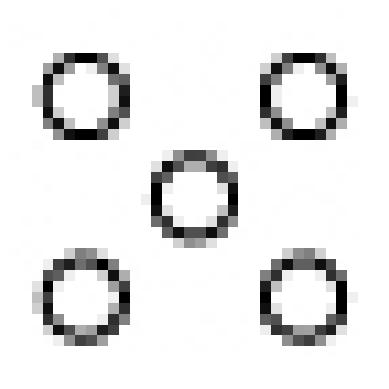

In [38]:
source = cv2.imread('rings.jpg')
plt.imshow(source)
plt.axis('off')
plt.show()

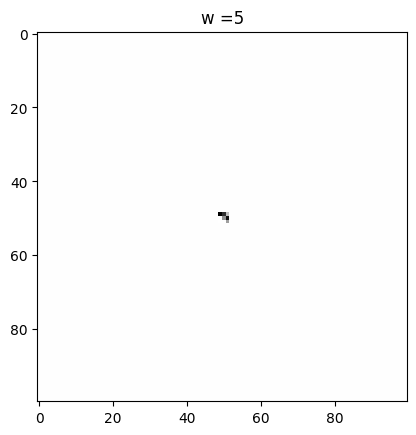

In [39]:
w = 5
target = synth_texture(source, w, [100, 100])
plt.imshow(target)
#plt.imshow(target, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
plt.title('w =' + str(w))
plt.show()

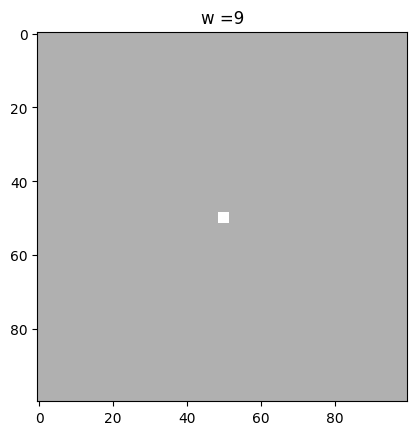

In [42]:
w = 9
target = synth_texture(source, w, [100, 100])
plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

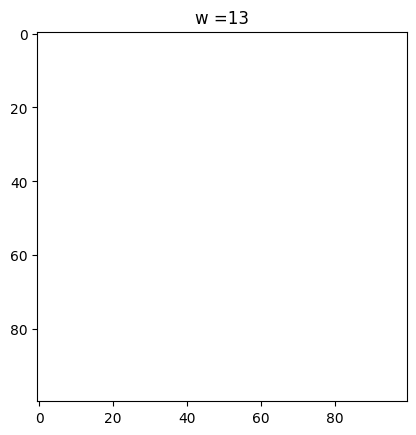

In [41]:
w = 13
target = synth_texture(source, w, [100, 100])
plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

Based on your results, remember to answer the questions in the PDF.